In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install transformers
!pip install diffusers
!pip install wandb
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.7 MB/s eta 0:00:0000:0100:01


## Load finetuned model 

In [3]:
import wandb
import torch
import logging
from diffusers import StableDiffusionPipeline
from transformers import (AutoTokenizer, AutoModelForCausalLM,
                          DataCollatorForLanguageModeling, pipeline)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import logging

# Create a custom logger
logger = logging.getLogger(__name__)

# Create handlers
c_handler = logging.StreamHandler()
c_handler.setLevel(logging.INFO)

In [5]:
# variables
PROJECT_ID = 'jbarata1998/song-generator/model-baseline_gpt2_finetune:v5'
MODEL_ID_TEXT_GEN = "gpt2"
MODEL_ID_SUMMARIZE = ""

In [6]:
# download model artifact from wandb
run = wandb.init()
artifact = run.use_artifact(PROJECT_ID, type='model')
artifact_dir = artifact.download()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact model-baseline_gpt2_finetune:v5, 474.75MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:7.0


In [7]:
# init tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID_TEXT_GEN)

In [8]:
# save tokenizer to load pipeline
tokenizer.save_pretrained(artifact_dir)

('./artifacts/model-baseline_gpt2_finetune:v5/tokenizer_config.json',
 './artifacts/model-baseline_gpt2_finetune:v5/special_tokens_map.json',
 './artifacts/model-baseline_gpt2_finetune:v5/vocab.json',
 './artifacts/model-baseline_gpt2_finetune:v5/merges.txt',
 './artifacts/model-baseline_gpt2_finetune:v5/added_tokens.json',
 './artifacts/model-baseline_gpt2_finetune:v5/tokenizer.json')

## Generate Album cover

In [58]:
class CoverGenerator:
    def __init__(self, gen_model: str, summarize_model: str, diffuse_model: str):
        self.gen_model = gen_model
        self.summarize_model = summarize_model
        self.diffuse_model = diffuse_model
        
    def gen_text(self, prompt: str, **kwargs: dict):
        generator = pipeline('text-generation', model=self.gen_model)
        result = generator(prompt, max_new_tokens=1024 - len(tokenizer.encode(prompt)), eos_token_id = kwargs["eos_token_id"])
        self.song = result[0]["generated_text"]
        self.title = self.song.split("TITLE:")[1].strip().replace("<",'')
        print(f"PROMPT: {prompt} \n\n SONG: \n\n {self.song}")
    
    def summarize_text(self, **kwargs: dict):
        try:
            summarizer = pipeline("summarization", self.summarize_model)
            # discard the prompt
            summary = summarizer(self.song.replace("Generate a song and its title:",'').split("[Chorus]")[1], min_length=kwargs.get("min_length", 5), max_length=kwargs.get("max_length", 75))
            self.song_summary = "Song title:" + self.title + ", " + summary[0]["summary_text"]
            print(f" SUMMARY: \n\n {self.song_summary}")
        except Exception as e:
            print(f"Exception {e} occurred")
        
    def gen_cover(self, summary, **kwargs: dict):
        pipe = StableDiffusionPipeline.from_pretrained(self.diffuse_model, torch_dtype=torch.float16)
        pipe = pipe.to("cuda")
        if summary:
            img_prompt = self.song_summary
        else:
            # use just title
            img_prompt = self.title
        image = pipe(img_prompt, height = kwargs["height"], width = kwargs["width"]).images[0]
        return image

In [60]:
test_prompt = "Well, good for you, I guess you moved on really easily\nYou found a new girl and it only took a couple weeks\nRemember when you said that you wanted to give me the world?"

cover_generator = CoverGenerator(gen_model = artifact_dir, summarize_model = "facebook/bart-large-cnn", diffuse_model = "runwayml/stable-diffusion-v1-5" )

In [61]:
cover_generator.gen_text(prompt = test_prompt, eos_token_id = tokenizer.encode("<END"))

Setting `pad_token_id` to `eos_token_id`:27 for open-end generation.


PROMPT: Well, good for you, I guess you moved on really easily
You found a new girl and it only took a couple weeks
Remember when you said that you wanted to give me the world? 

 SONG: 

 Well, good for you, I guess you moved on really easily
You found a new girl and it only took a couple weeks
Remember when you said that you wanted to give me the world?
Remember how I told you that you were going to marry someday?
Now you're waiting right here in my front door
Oh, yeah, it's finally time to leave
We got a couple of babies to look forward to
Sorry, I'm not sure to see your face in the photos

Well, I kinda had you believe in a month
You saw my face in the first chapter, yeah, you did too

Did you see me smile at the mall?
Did I smile, oh oh, yeah
Oh, yeah, it was really that good?
Did I smile, oh, yeah, yeah
Oh, yeah, it was really that good?
Do you still remember when I said, "Let's have a little kid?"
And when you said that I didn't have to leave?


[Verse 1]
Oh, and I thought to my

In [ ]:
# create summary
# Title - Chorus Summary as an input
cover_generator.summarize_text(min_length= 5, max_length= 75)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

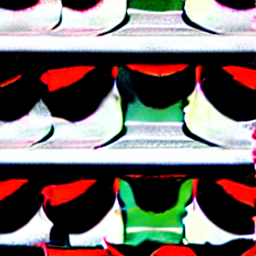

In [62]:
image = cover_generator.gen_cover(summary = False, height=256, width=256)
image